## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

<hr style="border:2px solid black"> </hr>

## Classifier class and functions

Functions to calculate the value of a gaussian distribution

In [2]:
def gaussian_dist(x , mean , variance):
    return (1 / np.sqrt(2*np.pi*variance)) * np.exp(((x-mean)**2) / (-2*variance))

In [3]:
def multivariate_gaussian_dist(x , mean, covariance):
    diff = x - mean
    return -0.5 * (diff.T @ covariance["inverse"] @ diff)

Function to get the confusion matrix

In [4]:
def get_confusion_matrix(Y_test, Y_predict, labels):
    number_of_classes = len(labels)
    confusion_matrix = np.zeros((number_of_classes, number_of_classes))
    for i in range(len(Y_test)):
        row = labels.index(Y_test[i])
        column = labels.index(Y_predict[i])
        confusion_matrix[row][column] += 1
    return confusion_matrix

Naive Bayes classifier class

In [5]:
class NaiveBayesClassifier:
    def __init__(self):
        self.labels = []
        self.count_classes = []
        self.m_classes = []
        self.v_classes = []
    
    def train(self, X_train, Y_train, labels):
        self.labels = labels
        X_classes = []
        for i in range (0, len(labels)):
            X_classes.append([])

        for i in range (0, len(X_train)):
            for j in range (0, len(labels)):
                if Y_train[i] == labels[j]:
                    X_classes[j].append(X_train[i])
                    break

        for i in range (0, len(X_classes)):
            X_classes[i] = np.array(X_classes[i])
            self.count_classes.append(len(X_classes[i]))
            self.m_classes.append(np.mean(X_classes[i], axis=0))
            self.v_classes.append(np.var(X_classes[i], axis=0))
    

    def predict(self, feature_vector):
        p_classes = []
        for i in range (0, len(self.labels)):
            mean_class = self.m_classes[i]
            variance_class = self.v_classes[i]
            likelihood = np.prod(gaussian_dist(feature_vector, mean_class, variance_class))
            prior = (self.count_classes[i] / sum(self.count_classes))
            posterior = likelihood * prior
            p_classes.append(posterior)
        
        max_p = -np.inf
        max_p_class = ""
        for i in range (0, len(self.labels)):
            if p_classes[i] > max_p:
                max_p = p_classes[i]
                max_p_class = labels[i]

        return max_p_class

Gaussian generative classifier class

In [6]:
class GaussianGenerativeClassifier:
    def __init__(self):
        self.labels = []
        self.count_classes = []
        self.m_classes = []
        self.covariance_matrix = {}
    
    def train(self, X_train, Y_train, labels):
        self.labels = labels
        X_classes = []
        for i in range (0, len(labels)):
            X_classes.append([])

        for i in range (0, len(X_train)):
            for j in range (0, len(labels)):
                if Y_train[i] == labels[j]:
                    X_classes[j].append(X_train[i])
                    break

        number_of_datapoints = X_train.shape[0]
        number_of_features = X_train.shape[1]
        covariance_matrix = np.zeros((number_of_features, number_of_features))
        for i in range (0, len(X_classes)):
            X_classes[i] = np.array(X_classes[i])
            n_class = len(X_classes[i])
            m_class = np.mean(X_classes[i], axis=0)
            for j in range (0, len(X_classes[i])):
                diff = (X_classes[i][j] - m_class).reshape(-1, 1)
                covariance_matrix += (diff @ diff.T)
            self.count_classes.append(n_class)
            self.m_classes.append(m_class)
        
        covariance_matrix /= number_of_datapoints
        self.covariance_matrix["matrix"] = covariance_matrix
        self.covariance_matrix["inverse"] = np.linalg.pinv(covariance_matrix)
    
    
    def predict(self, feature_vector):
        p_classes = []
        for i in range (0, len(self.labels)):
            likelihood = multivariate_gaussian_dist(feature_vector, self.m_classes[i], self.covariance_matrix)
            prior = self.count_classes[i] / sum(self.count_classes)
            posterior = likelihood * prior
            p_classes.append(posterior)
        
        max_p = -np.inf
        max_p_class = ""
        for i in range (0, len(self.labels)):
            if p_classes[i] > max_p:
                max_p = p_classes[i]
                max_p_class = labels[i]

        return max_p_class

<hr style="border:2px solid black"> </hr>

## Getting the images and their labels

Read training and testing images

In [7]:
airplane_train_images = np.array([cv2.imread("Data/Train/airplane/"+str(i)+".jpg") for i in range(0, 5000)])
automobile_train_images = np.array([cv2.imread("Data/Train/automobile/"+str(i)+".jpg") for i in range(0, 5000)])
frog_train_images = np.array([cv2.imread("Data/Train/frog/"+str(i)+".jpg") for i in range(0, 5000)])

airplane_test_images = np.array([cv2.imread("Data/Test/airplane/"+str(i)+".jpg") for i in range(0, 1000)])
automobile_test_images = np.array([cv2.imread("Data/Test/automobile/"+str(i)+".jpg") for i in range(0, 1000)])
frog_test_images = np.array([cv2.imread("Data/Test/frog/"+str(i)+".jpg") for i in range(0, 1000)])

Getting labels for all the classes train and test data

In [8]:
Y_train = ["airplane" for i in range(airplane_train_images.shape[0])]
Y_train += ["automobile" for i in range(automobile_train_images.shape[0])]
Y_train += ["frog" for i in range(frog_train_images.shape[0])]

Y_test = ["airplane" for i in range(airplane_test_images.shape[0])]
Y_test += ["automobile" for i in range(automobile_test_images.shape[0])]
Y_test += ["frog" for i in range(frog_test_images.shape[0])]

labels = ["airplane", "automobile", "frog"]

<hr style="border:2px solid black"> </hr>

## Training and testing the classifiers

Initialize confusion matrices arrays

In [9]:
confusion_matrices_nb = []
confusion_matrices_gm = []

### 32X32

Transforming the images into feature vectors and normalizing them

In [10]:
X_airplane_train_32 = np.array([airplane_train_images[i].reshape(-1) for i in range(0, airplane_train_images.shape[0])])
X_automobile_train_32 = np.array([automobile_train_images[i].reshape(-1) for i in range(0, automobile_train_images.shape[0])])
X_frog_train_32 = np.array([frog_train_images[i].reshape(-1) for i in range(0, frog_train_images.shape[0])])

X_airplane_test_32 = np.array([airplane_test_images[i].reshape(-1) for i in range(0, airplane_test_images.shape[0])])
X_automobile_test_32 = np.array([automobile_test_images[i].reshape(-1) for i in range(0, automobile_test_images.shape[0])])
X_frog_test_32 = np.array([frog_test_images[i].reshape(-1) for i in range(0, frog_test_images.shape[0])])

X_train_32 = np.concatenate((X_airplane_train_32, X_automobile_train_32, X_frog_train_32)) / 255.0
X_test_32 = np.concatenate((X_airplane_test_32, X_automobile_test_32, X_frog_test_32)) / 255.0

Train and test Naive Bayes classifier

In [11]:
nb_classifier_32 = NaiveBayesClassifier()
nb_classifier_32.train(X_train_32, Y_train, labels)

In [ ]:
Y_predict_nb_32 = []
for i in range(X_test_32.shape[0]):
    Y_predict_nb_32.append(nb_classifier_32.predict(X_test_32[i]))

confusion_matrix_nb_32 = get_confusion_matrix(Y_test, Y_predict_nb_32, labels)
confusion_matrices_nb += [confusion_matrix_nb_32]

Train and test gaussian generative classifier

In [13]:
gm_classifier_32 = GaussianGenerativeClassifier()
gm_classifier_32.train(X_train_32, Y_train, labels)

In [14]:
Y_predict_gm_32 = []
for i in range(X_test_32.shape[0]):
    Y_predict_gm_32.append(gm_classifier_32.predict(X_test_32[i]))

confusion_matrix_gm_32 = get_confusion_matrix(Y_test, Y_predict_gm_32, labels)
confusion_matrices_gm += [confusion_matrix_gm_32]

### 16X16

Transforming the images into feature vectors and normalizing them

In [15]:
X_airplane_train_16 = np.array([cv2.resize(airplane_train_images[i], (16,16), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, airplane_train_images.shape[0])])
X_automobile_train_16 = np.array([cv2.resize(automobile_train_images[i], (16,16), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, automobile_train_images.shape[0])])
X_frog_train_16 = np.array([cv2.resize(frog_train_images[i], (16,16), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, frog_train_images.shape[0])])

X_airplane_test_16 = np.array([cv2.resize(airplane_test_images[i], (16,16), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, airplane_test_images.shape[0])])
X_automobile_test_16 = np.array([cv2.resize(automobile_test_images[i], (16,16), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, automobile_test_images.shape[0])])
X_frog_test_16 = np.array([cv2.resize(frog_test_images[i], (16,16), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, frog_test_images.shape[0])])

X_train_16 = np.concatenate((X_airplane_train_16, X_automobile_train_16, X_frog_train_16)) / 255.0
X_test_16 = np.concatenate((X_airplane_test_16, X_automobile_test_16, X_frog_test_16)) / 255.0

Train and test Naive Bayes classifier

In [16]:
nb_classifier_16 = NaiveBayesClassifier()
nb_classifier_16.train(X_train_16, Y_train, labels)

In [17]:
Y_predict_nb_16 = []
for i in range(X_test_16.shape[0]):
    Y_predict_nb_16.append(nb_classifier_16.predict(X_test_16[i]))

confusion_matrix_nb_16 = get_confusion_matrix(Y_test, Y_predict_nb_16, labels)
confusion_matrices_nb += [confusion_matrix_nb_16]

Train and test gaussian generative classifier

In [18]:
gm_classifier_16 = GaussianGenerativeClassifier()
gm_classifier_16.train(X_train_16, Y_train, labels)

In [19]:
Y_predict_gm_16 = []
for i in range(X_test_16.shape[0]):
    Y_predict_gm_16.append(gm_classifier_16.predict(X_test_16[i]))

confusion_matrix_gm_16 = get_confusion_matrix(Y_test, Y_predict_gm_16, labels)
confusion_matrices_gm += [confusion_matrix_gm_16]

### 8X8

Transforming the images into feature vectors and normalizing them

In [20]:
X_airplane_train_8 = np.array([cv2.resize(airplane_train_images[i], (8,8), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, airplane_train_images.shape[0])])
X_automobile_train_8 = np.array([cv2.resize(automobile_train_images[i], (8,8), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, automobile_train_images.shape[0])])
X_frog_train_8 = np.array([cv2.resize(frog_train_images[i], (8,8), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, frog_train_images.shape[0])])

X_airplane_test_8 = np.array([cv2.resize(airplane_test_images[i], (8,8), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, airplane_test_images.shape[0])])
X_automobile_test_8 = np.array([cv2.resize(automobile_test_images[i], (8,8), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, automobile_test_images.shape[0])])
X_frog_test_8 = np.array([cv2.resize(frog_test_images[i], (8,8), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, frog_test_images.shape[0])])

X_train_8 = np.concatenate((X_airplane_train_8, X_automobile_train_8, X_frog_train_8)) / 255.0
X_test_8 = np.concatenate((X_airplane_test_8, X_automobile_test_8, X_frog_test_8)) / 255.0

Train and test Naive Bayes classifier

In [21]:
nb_classifier_8 = NaiveBayesClassifier()
nb_classifier_8.train(X_train_8, Y_train, labels)

In [22]:
Y_predict_nb_8 = []
for i in range(X_test_8.shape[0]):
    Y_predict_nb_8.append(nb_classifier_8.predict(X_test_8[i]))

confusion_matrix_nb_8 = get_confusion_matrix(Y_test, Y_predict_nb_8, labels)
confusion_matrices_nb += [confusion_matrix_nb_8]

Train and test gaussian generative classifier

In [23]:
gm_classifier_8 = GaussianGenerativeClassifier()
gm_classifier_8.train(X_train_8, Y_train, labels)

In [24]:
Y_predict_gm_8 = []
for i in range(X_test_8.shape[0]):
    Y_predict_gm_8.append(gm_classifier_8.predict(X_test_8[i]))

confusion_matrix_gm_8 = get_confusion_matrix(Y_test, Y_predict_gm_8, labels)
confusion_matrices_gm += [confusion_matrix_gm_8]

### 4X4

Transforming the images into feature vectors and normalizing them

In [25]:
X_airplane_train_4 = np.array([cv2.resize(airplane_train_images[i], (4,4), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, airplane_train_images.shape[0])])
X_automobile_train_4 = np.array([cv2.resize(automobile_train_images[i], (4,4), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, automobile_train_images.shape[0])])
X_frog_train_4 = np.array([cv2.resize(frog_train_images[i], (4,4), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, frog_train_images.shape[0])])

X_airplane_test_4 = np.array([cv2.resize(airplane_test_images[i], (4,4), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, airplane_test_images.shape[0])])
X_automobile_test_4 = np.array([cv2.resize(automobile_test_images[i], (4,4), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, automobile_test_images.shape[0])])
X_frog_test_4 = np.array([cv2.resize(frog_test_images[i], (4,4), interpolation = cv2.INTER_AREA).reshape(-1) for i in range(0, frog_test_images.shape[0])])

X_train_4 = np.concatenate((X_airplane_train_4, X_automobile_train_4, X_frog_train_4)) / 255.0
X_test_4 = np.concatenate((X_airplane_test_4, X_automobile_test_4, X_frog_test_4)) / 255.0

Train and test Naive Bayes classifier

In [26]:
nb_classifier_4 = NaiveBayesClassifier()
nb_classifier_4.train(X_train_4, Y_train, labels)

In [27]:
Y_predict_nb_4 = []
for i in range(X_test_4.shape[0]):
    Y_predict_nb_4.append(nb_classifier_4.predict(X_test_4[i]))

confusion_matrix_nb_4 = get_confusion_matrix(Y_test, Y_predict_nb_4, labels)
confusion_matrices_nb += [confusion_matrix_nb_4]

Train and test gaussian generative classifier

In [28]:
gm_classifier_4 = GaussianGenerativeClassifier()
gm_classifier_4.train(X_train_4, Y_train, labels)

In [29]:
Y_predict_gm_4 = []
for i in range(X_test_4.shape[0]):
    Y_predict_gm_4.append(gm_classifier_4.predict(X_test_4[i]))

confusion_matrix_gm_4 = get_confusion_matrix(Y_test, Y_predict_gm_4, labels)
confusion_matrices_gm += [confusion_matrix_gm_4]

<hr style="border:2px solid black"> </hr>

## Plotting the results

In [30]:
confusion_matrices = confusion_matrices_nb + confusion_matrices_gm

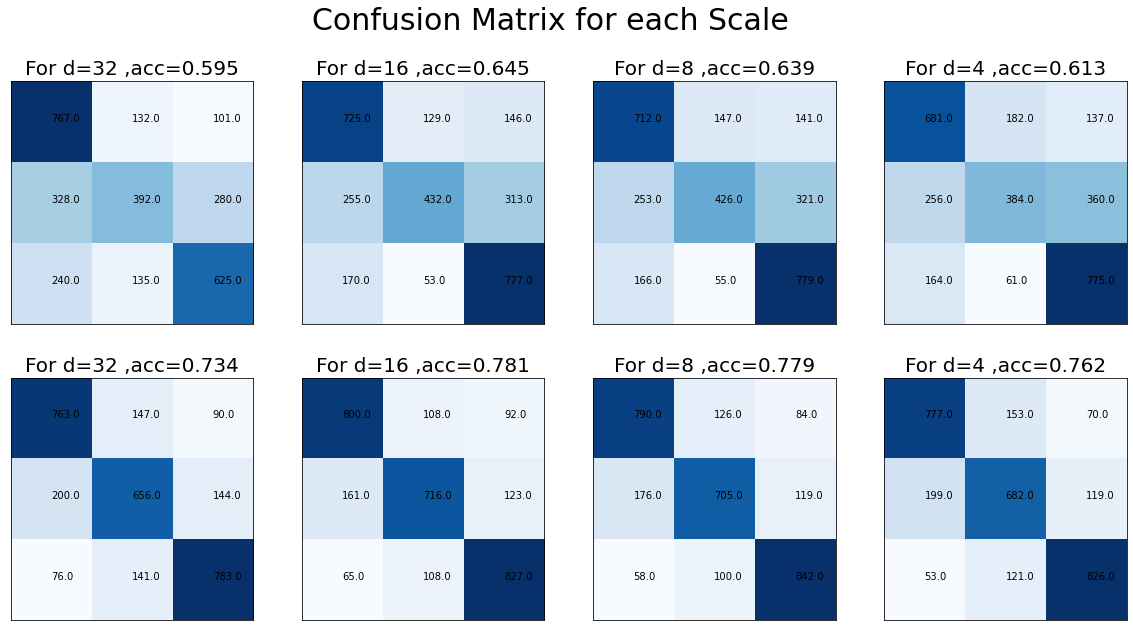

In [31]:
dims = [32,16,8,4,32,16,8,4]
fig, axs = plt.subplots(2, 4,figsize=(20,10))
fig.suptitle("Confusion Matrix for each Scale",fontsize=30)
for pi in range(0,axs.shape[0]):
    for pj in range(0,axs.shape[1]):
        index = np.round(pi*4+pj)
        cm = confusion_matrices[index]
        axs[pi,pj].matshow(cm,cmap="Blues")
        axs[pi,pj].set_title("For d="+str(dims[index])+" ,acc="+str(np.round(np.diag(cm).sum()/3000,3)),fontsize=20)
        for i in range(0,cm.shape[0]):
            for j in range(0,cm.shape[1]):
                axs[pi,pj].set_xticks([])
                axs[pi,pj].set_yticks([])
                axs[pi,pj].annotate(cm[i,j],(j,i))
plt.savefig("figure_confusion_matrices")

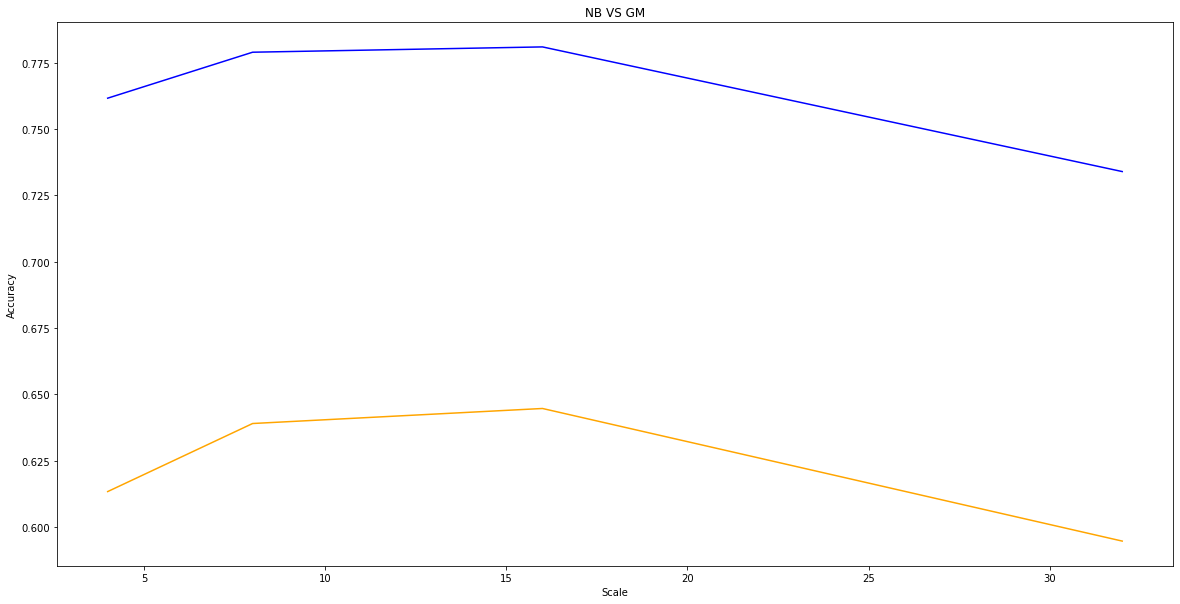

In [32]:
plt.figure(figsize=(20,10))
plt.plot(dims[:4],[np.diag(cm).sum()/3000 for cm in confusion_matrices_nb],color='orange')
plt.plot(dims[:4],[np.diag(cm).sum()/3000 for cm in confusion_matrices_gm],color='blue')
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('NB VS GM')
plt.savefig("figure_comparison")

<hr style="border:2px solid black"> </hr>

## Comments

Based on the results shown above, applying the maximum likelihood estimation of the Gaussian generative model is better in classifying the images than the Naive Bayes classifier. This is due to the assumption of the Naive Bayes classifier that the different features (dimensions) are independant, while in general they may be. However, the Gaussian generative model accounts for dependencies between the features as the dependancies are calculated in the covariance matrix by calculating the values of the covariance between the features, which leads to better results.

<hr style="border:2px solid black"> </hr>